In [1]:
from ldm.models.diffusion import options

options.LDM_DISTILLATION_ONLY = True

from threestudio.models.guidance import zero123_guidance
from omegaconf import OmegaConf

guidance_cfg = dict(
    pretrained_model_name_or_path= "/svl/u/ksarge/nextnvs/zeronvs.ckpt",
    pretrained_config= "/svl/u/ksarge/nextnvs/zeronvs_config.yaml",
    guidance_scale= 7.5,
    cond_image_path = "/svl/u/ksarge/nextnvs/motorcycle.png",  # unused
    min_step_percent=[0,.75,.02,1000],
    max_step_percent=[1000, 0.98, 0.025, 2500],
    vram_O=False
)

guidance = zero123_guidance.Zero123Guidance(OmegaConf.create(guidance_cfg))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/svl/u/ksarge/miniforge-pypy3/envs/nerfstudio_zeronvs/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
Loading Zero123 ...


SDS distillation only, disabling some functionality...
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Loaded Zero123!


In [2]:
from PIL import Image
import numpy as np
import torch

cond_image_pil = Image.open("motorcycle.png").convert("RGB")
cond_image = torch.from_numpy(np.array(cond_image_pil)).cuda() / 255.

c_crossattn, c_concat = guidance.get_img_embeds(
    cond_image.permute((2, 0, 1))[None])

cond_camera = np.eye(4)  # identity camera pose
target_camera = cond_camera.copy()
target_camera[:3, -1] = np.array([.125, .125, .125])  # perturb the cond pose

target_camera = torch.from_numpy(target_camera[None]).cuda().to(torch.float32)
cond_camera = torch.from_numpy(cond_camera[None]).cuda().to(torch.float32)

In [6]:
camera_batch = {
    "target_cam2world": target_camera,
    "cond_cam2world": cond_camera,
    "fov_deg": torch.from_numpy(np.array([45.0])).cuda().to(torch.float32)
}

guidance.cfg.precomputed_scale=.7
cond = guidance.get_cond_from_known_camera(
    camera_batch,
    c_crossattn=c_crossattn,
    c_concat=c_concat,
    # precomputed_scale=.7,
)

In [8]:
novel_view = guidance.gen_from_cond(cond)
novel_view_pil = Image.fromarray(np.clip(novel_view[0]*255, 0, 255).astype(np.uint8))

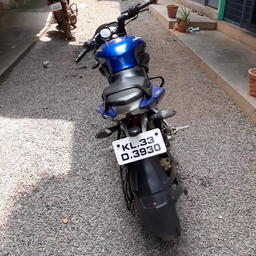

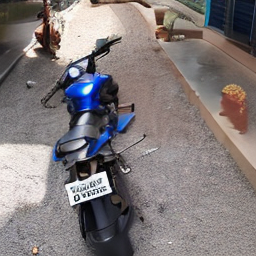

In [9]:
display(cond_image_pil)
display(novel_view_pil)